In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir(r'/content/drive/My Drive')  # Change the directory 

# Requirements

In [ ]:
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2

In [ ]:
#@title MNIST-1D utils

# transformations of the templates which will make them harder to classify
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42,
            'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}
    return arg_dict if as_dict else ObjectView(arg_dict)


def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=4)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# basic 1D templates for the 10 digits
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset


In [ ]:
from mnist1d_utils import *

# Dataset

In [ ]:
dataset = make_dataset()

**Dataset:** A dictionary conaining 4000 train and 1000 test data.

Keys of the dictionary:

* 'x' : Training data.

* 'y' : Training labels.

* 'x_test' : Test data.

* 'y_test : Test labels.

* 't' : Mapping data points to spatial locations.

* 'templates' : The templates for the digits 0-9.

Text(0.5, 1.0, 'predicted class: 6')

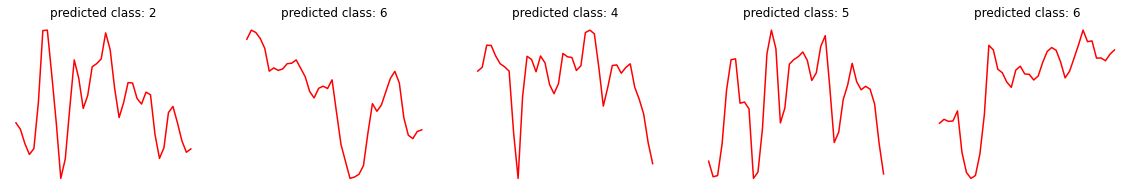

In [ ]:
#@title Show some examples from the MNIST 1-D dataset

plt.figure(figsize=(20,3))

plt.subplot(151)
plt.plot(dataset['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][0]))

plt.subplot(152)
plt.plot(dataset['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][1]))

plt.subplot(153)
plt.plot(dataset['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][2]))

plt.subplot(154)
plt.plot(dataset['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][3]))

plt.subplot(155)
plt.plot(dataset['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][4]))

Text(0.5, 1.0, 'predicted class: 9')

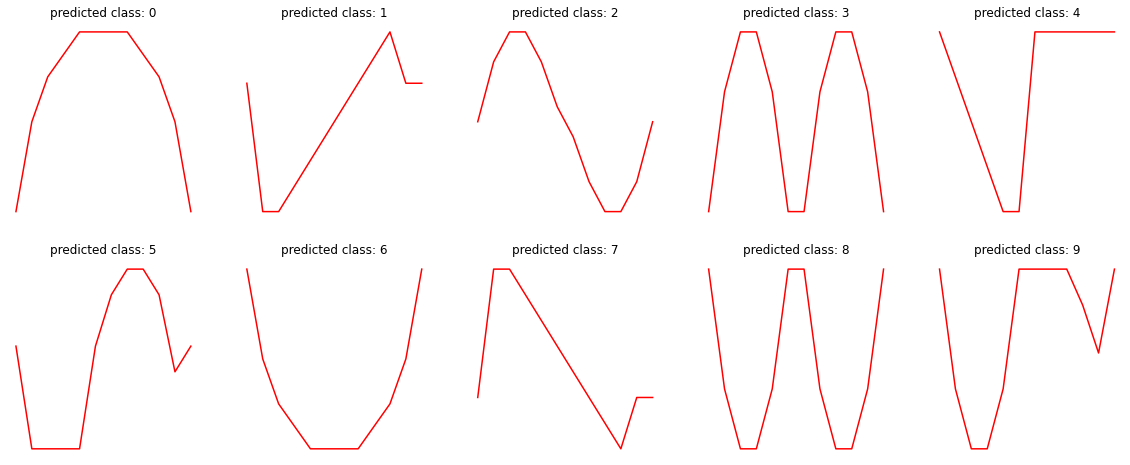

In [ ]:
#@title Show the digit templates in the MNIST 1-D dataset 

plt.figure(figsize=(20,8))

plt.subplot(251)
plt.plot(dataset['templates']['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: 0')

plt.subplot(252)
plt.plot(dataset['templates']['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: 1')

plt.subplot(253)
plt.plot(dataset['templates']['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: 2')

plt.subplot(254)
plt.plot(dataset['templates']['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: 3')

plt.subplot(255)
plt.plot(dataset['templates']['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: 4')

plt.subplot(256)
plt.plot(dataset['templates']['x'][5], 'r')
plt.axis('off')
plt.title('predicted class: 5')

plt.subplot(257)
plt.plot(dataset['templates']['x'][6], 'r')
plt.axis('off')
plt.title('predicted class: 6')

plt.subplot(258)
plt.plot(dataset['templates']['x'][7], 'r')
plt.axis('off')
plt.title('predicted class: 7')

plt.subplot(259)
plt.plot(dataset['templates']['x'][8], 'r')
plt.axis('off')
plt.title('predicted class: 8')

plt.subplot(2,5,10)
plt.plot(dataset['templates']['x'][9], 'r')
plt.axis('off')
plt.title('predicted class: 9')

Saving the dataset

In [ ]:
f = open("MNIST1D.pkl","wb")
pickle.dump(dataset,f)
f.close()

# Model Creation

**Creating model :**

A 1-Dimensional CNN, containing 3 convolutional layers, followed by a fully-connected output layer.

In [ ]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv1D(filters=25, kernel_size=(5), padding='same', activation='relu', input_shape=(40,1), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv1D(filters=25, kernel_size=(3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv1D(filters=25, kernel_size=(3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Flatten())
model.add(Dense(10, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

Printing the model's summary.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 25)            150       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 25)            1900      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 25)            1900      
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10010     
Total params: 13,960
Trainable params: 13,960
Non-trainable params: 0
_________________________________________________________________


# Training the model

Compiling the model

Loss function: Cross-entropy

Optimizer: Stochastic Gradient Descent (SGD)

Tensorboard: For recording the training procedure

In [ ]:
# Compile the model
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'])

tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log', write_graph=True)

In [ ]:
model.fit(x=np.expand_dims(dataset['x'], axis=-1), y=dataset['y'], validation_split=0.1, callbacks=[tensorboard_cb], epochs=200)

Epoch 1/200
113/113 [==============================] - 3s 19ms/step - loss: 3.6917 - accuracy: 0.1333 - val_loss: 3.3785 - val_accuracy: 0.2050
Epoch 2/200
113/113 [==============================] - 1s 5ms/step - loss: 3.3671 - accuracy: 0.2016 - val_loss: 3.3227 - val_accuracy: 0.2075
Epoch 3/200
113/113 [==============================] - 1s 5ms/step - loss: 3.2927 - accuracy: 0.2352 - val_loss: 3.2804 - val_accuracy: 0.2125
Epoch 4/200
113/113 [==============================] - 1s 5ms/step - loss: 3.2419 - accuracy: 0.2499 - val_loss: 3.2213 - val_accuracy: 0.2500
Epoch 5/200
113/113 [==============================] - 1s 5ms/step - loss: 3.1787 - accuracy: 0.2757 - val_loss: 3.1455 - val_accuracy: 0.2750
Epoch 6/200
113/113 [==============================] - 1s 5ms/step - loss: 3.0902 - accuracy: 0.3078 - val_loss: 3.0887 - val_accuracy: 0.2775
Epoch 7/200
113/113 [==============================] - 1s 5ms/step - loss: 3.0157 - accuracy: 0.3295 - val_loss: 2.9986 - val_accuracy: 0.312

Save the model

In [ ]:
model.save('MNIST1D.h5')

# Plotting the training progress

# Load the model

In [ ]:
model=load_model('MNIST1D.h5')

Loading training progress



In [ ]:
def my_summary_iterator(path):
  for r in tf_record.tf_record_iterator(path):
    yield event_pb2.Event.FromString(r)
train_acc = []
train_loss = []
train_lr = []
#print('log/train/' + os.listdir('log/train')[2])
for e in my_summary_iterator('log/train/' + os.listdir('log/train')[2]):
  for v in e.summary.value:
    if v.tag == 'epoch_accuracy':
      train_acc.append(v.simple_value)
    elif v.tag == 'epoch_loss':
      train_loss.append(v.simple_value)

Text(0.5, 1.0, 'Training progress: Accuracy')

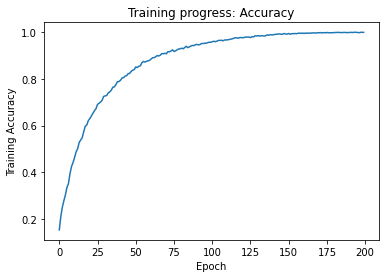

In [ ]:
plt.plot(np.arange(len(train_acc)), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training progress: Accuracy')

Text(0.5, 1.0, 'Training progress: Loss')

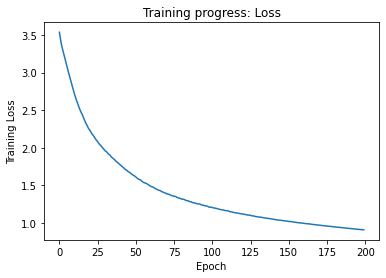

In [ ]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training progress: Loss')